<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/weak_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [3]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [4]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [5]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)


In [6]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 80,000, 20,000, 8,000

tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)

Files already downloaded and verified


In [7]:
tr_subset, val_subset = torch.utils.data.random_split(tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))

test_set = datasets.STL10(root = "./data", split = "test", transform = transforms.ToTensor(), download=True)

Files already downloaded and verified


In [8]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4)
test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4)

In [9]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


In [10]:
img_train_set = tr_subset.dataset.data[tr_subset.indices]
label_train_set = tr_subset.dataset.labels[tr_subset.indices]

img_val_set = val_subset.dataset.data[val_subset.indices]
label_val_set = val_subset.dataset.labels[val_subset.indices]

img_test_set = test_set.data
label_test_set = test_set.labels

In [11]:
img_val_set.shape

(20000, 3, 96, 96)

In [12]:
label_val_set #No Label

array([-1, -1, -1, ..., -1, -1, -1])

In [13]:
img_test_set.shape

(8000, 3, 96, 96)

In [14]:
label_test_set

array([6, 7, 5, ..., 8, 8, 8], dtype=uint8)

In [15]:
label_test_set
img_test_set

array([[[[227, 227, 226, ..., 229, 228, 229],
         [227, 226, 228, ..., 228, 229, 228],
         [227, 227, 227, ..., 228, 229, 229],
         ...,
         [222, 227, 231, ..., 170, 196, 199],
         [233, 213, 202, ..., 203, 206, 194],
         [224, 225, 224, ..., 196, 179, 174]],

        [[235, 235, 236, ..., 233, 234, 235],
         [235, 235, 235, ..., 233, 233, 234],
         [235, 236, 236, ..., 233, 233, 233],
         ...,
         [174, 184, 186, ..., 147, 163, 167],
         [192, 174, 163, ..., 168, 167, 158],
         [181, 184, 184, ..., 153, 146, 138]],

        [[237, 237, 237, ..., 236, 236, 235],
         [237, 237, 237, ..., 236, 236, 234],
         [237, 236, 235, ..., 236, 236, 235],
         ...,
         [115, 119, 120, ..., 114, 122, 135],
         [133, 121, 109, ..., 126, 121, 114],
         [131, 130, 134, ..., 104, 107, 101]]],


       [[[ 86, 100, 104, ..., 114, 118, 116],
         [ 82,  92, 102, ..., 109, 119, 119],
         [ 74,  86,  96, ..., 

In [16]:
img_train_set_arr = np.array(img_train_set)
img_val_set_arr = np.array(img_val_set)
img_test_set_arr = np.array(img_test_set)

In [17]:
print(len(tr_subset))

80000


In [18]:
Gs_blur_weak_tr_dataset = []
for i in range(80000):
  hat_img_train_set_arr = cv2.GaussianBlur(img_train_set_arr[i], (11,11),0)
  hat_img_train_set_tensor_byte = torch.from_numpy(hat_img_train_set_arr)
  hat_img_train_set_tensor_float = hat_img_train_set_tensor_byte.float()
  hat_img_train_set_tensor_normal = hat_img_train_set_tensor_float.div(255.0)
  Gs_blur_weak_tr_dataset.append([hat_img_train_set_tensor_normal,0])

In [19]:
Gs_blur_weak_val_dataset = []
for j in range(10000):
  hat_img_val_set_arr = cv2.GaussianBlur(img_val_set_arr[j],  (11,11),0)
  hat_img_val_set_tensor_byte = torch.from_numpy(hat_img_val_set_arr)
  hat_img_val_set_tensor_float = hat_img_val_set_tensor_byte.float()
  hat_img_val_set_tensor_normal = hat_img_val_set_tensor_float.div(255.0)
  Gs_blur_weak_val_dataset.append([hat_img_val_set_tensor_normal,0])

In [36]:
Gs_blur_strong_val_dataset = []
for j in range(10000):
  hat_img_val_set_arr = cv2.GaussianBlur(img_val_set_arr[j], (41,41),0)
  hat_img_val_set_tensor_byte = torch.from_numpy(hat_img_val_set_arr)
  hat_img_val_set_tensor_float = hat_img_val_set_tensor_byte.float()
  hat_img_val_set_tensor_normal = hat_img_val_set_tensor_float.div(255.0)
  Gs_blur_strong_val_dataset.append([hat_img_val_set_tensor_normal,0])


In [25]:
Gs_blur_weak_tr_dataloader = DataLoader(Gs_blur_weak_tr_dataset, batch_size = batch_size, num_workers = 4)
Gs_blur_weak_val_dataloader = DataLoader(Gs_blur_weak_val_dataset, batch_size = batch_size, num_workers = 4) 


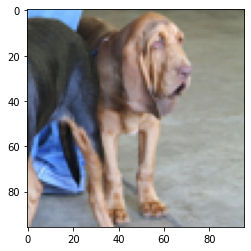

In [72]:

it,_ = next(iter(val_dataloader))
it_arr = it.numpy()
plt.imshow(it_arr[0].transpose(1,2,0))

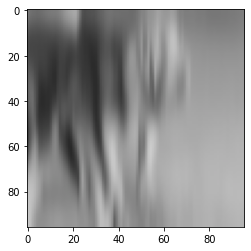

In [37]:
Gs_blur_strong_val_dataloader = DataLoader(Gs_blur_strong_val_dataset, batch_size = batch_size, num_workers = 4) 

it,_ = next(iter(Gs_blur_strong_val_dataloader))
it_arr = it.numpy()
plt.imshow(it_arr[0].transpose(1,2,0))

print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_weak_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_weak_tr_arr = np.append(Gaussian_blur_weak_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_weak_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_weak_tr_arr.shape)

type(Gaussian_blur_weak_tr_arr)

In [20]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [22]:
#Instantiate the model
model_moderate = DenosingAutoencoder()
model_strong = DenosingAutoencoder()



In [23]:
#Epochs
n_epochs = 25

#Optimizer


optimizer_moderate = torch.optim.Adam(model_moderate.parameters(), lr=0.001, weight_decay  = 1e-04)

optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)



# lr 0.1에서 1이 최적. 



In [26]:
len(tr_dataloader)

5000

In [27]:
len(val_dataloader)

1250

cuda
Epoch : [1/25] 

Training Loss: 0.015861	 validation Loss 0.006683
PNSR :20.13 	 SSIM : 0.61
PNSR :17.28 	 SSIM : 0.68
PNSR :7.19 	 SSIM : 0.44
PNSR :17.41 	 SSIM : 0.58
PNSR :19.94 	 SSIM : 0.88


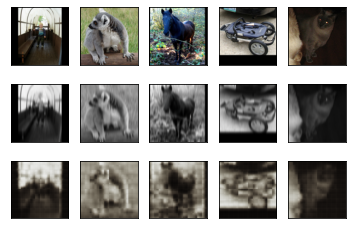

Epoch : [2/25] 

Training Loss: 0.013467	 validation Loss 0.006581
PNSR :21.34 	 SSIM : 0.62
PNSR :17.70 	 SSIM : 0.68
PNSR :7.27 	 SSIM : 0.45
PNSR :17.55 	 SSIM : 0.59
PNSR :20.45 	 SSIM : 0.89


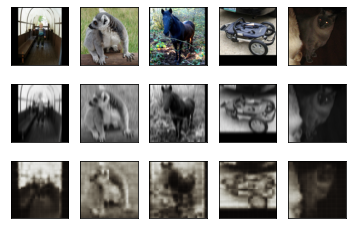

Epoch : [3/25] 

Training Loss: 0.013365	 validation Loss 0.006573
PNSR :21.70 	 SSIM : 0.63
PNSR :17.52 	 SSIM : 0.68
PNSR :7.29 	 SSIM : 0.45
PNSR :17.50 	 SSIM : 0.59
PNSR :20.33 	 SSIM : 0.89


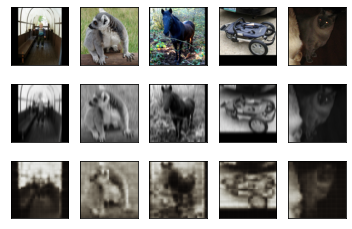

Epoch : [4/25] 

Training Loss: 0.013318	 validation Loss 0.006553
PNSR :22.08 	 SSIM : 0.63
PNSR :17.59 	 SSIM : 0.69
PNSR :7.30 	 SSIM : 0.45
PNSR :17.49 	 SSIM : 0.59
PNSR :20.42 	 SSIM : 0.89


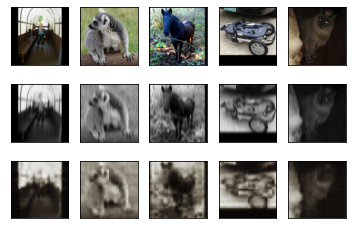

Epoch : [5/25] 

Training Loss: 0.013293	 validation Loss 0.006545
PNSR :22.32 	 SSIM : 0.63
PNSR :17.65 	 SSIM : 0.69
PNSR :7.31 	 SSIM : 0.45
PNSR :17.50 	 SSIM : 0.59
PNSR :20.46 	 SSIM : 0.89


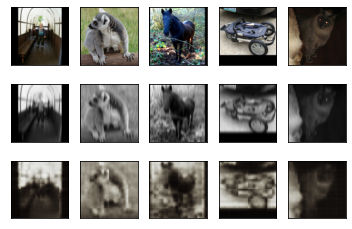

Epoch : [6/25] 

Training Loss: 0.013273	 validation Loss 0.006559
PNSR :22.66 	 SSIM : 0.63
PNSR :17.75 	 SSIM : 0.68
PNSR :7.34 	 SSIM : 0.45
PNSR :17.33 	 SSIM : 0.59
PNSR :20.57 	 SSIM : 0.89


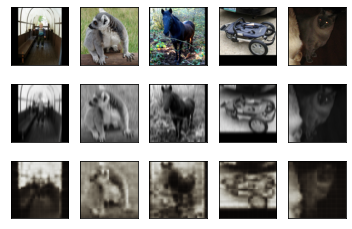

Epoch : [7/25] 

Training Loss: 0.013259	 validation Loss 0.006577
PNSR :22.95 	 SSIM : 0.63
PNSR :17.76 	 SSIM : 0.68
PNSR :7.37 	 SSIM : 0.45
PNSR :17.25 	 SSIM : 0.59
PNSR :20.55 	 SSIM : 0.89


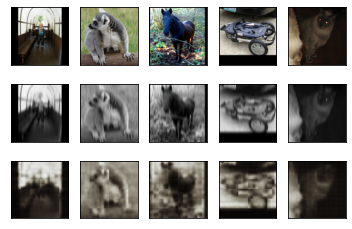

Epoch : [8/25] 

Training Loss: 0.013246	 validation Loss 0.006546
PNSR :22.88 	 SSIM : 0.63
PNSR :17.74 	 SSIM : 0.68
PNSR :7.31 	 SSIM : 0.45
PNSR :17.47 	 SSIM : 0.59
PNSR :20.57 	 SSIM : 0.89


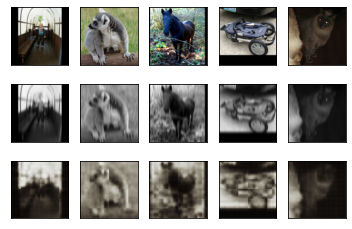

Epoch : [9/25] 

Training Loss: 0.013232	 validation Loss 0.006547
PNSR :22.88 	 SSIM : 0.63
PNSR :17.65 	 SSIM : 0.68
PNSR :7.30 	 SSIM : 0.45
PNSR :17.54 	 SSIM : 0.59
PNSR :20.44 	 SSIM : 0.89


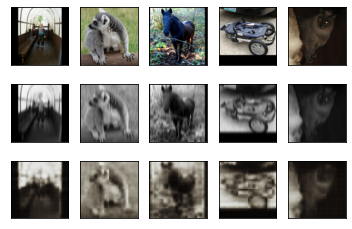

Epoch : [10/25] 

Training Loss: 0.013223	 validation Loss 0.006590
PNSR :22.71 	 SSIM : 0.63
PNSR :17.46 	 SSIM : 0.68
PNSR :7.26 	 SSIM : 0.45
PNSR :17.55 	 SSIM : 0.59
PNSR :20.22 	 SSIM : 0.89


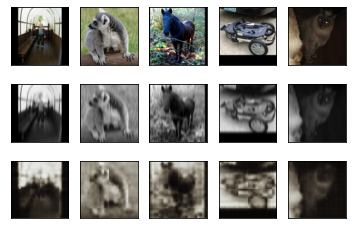

Epoch : [11/25] 

Training Loss: 0.013216	 validation Loss 0.006545
PNSR :22.96 	 SSIM : 0.63
PNSR :17.60 	 SSIM : 0.68
PNSR :7.28 	 SSIM : 0.45
PNSR :17.53 	 SSIM : 0.59
PNSR :20.36 	 SSIM : 0.89


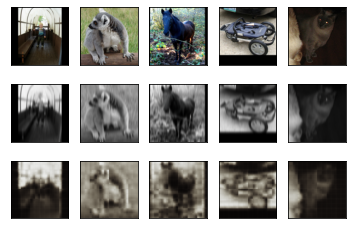

Epoch : [12/25] 

Training Loss: 0.013211	 validation Loss 0.006646
PNSR :22.65 	 SSIM : 0.63
PNSR :17.17 	 SSIM : 0.68
PNSR :7.18 	 SSIM : 0.45
PNSR :17.56 	 SSIM : 0.59
PNSR :19.86 	 SSIM : 0.89


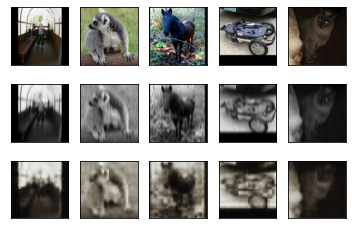

Epoch : [13/25] 

Training Loss: 0.013207	 validation Loss 0.006617
PNSR :22.73 	 SSIM : 0.63
PNSR :17.28 	 SSIM : 0.68
PNSR :7.19 	 SSIM : 0.45
PNSR :17.52 	 SSIM : 0.59
PNSR :20.02 	 SSIM : 0.89


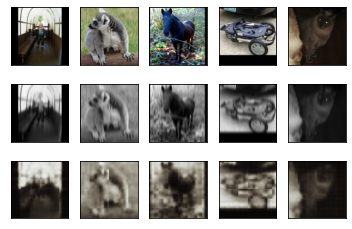

Epoch : [14/25] 

Training Loss: 0.013204	 validation Loss 0.006607
PNSR :22.69 	 SSIM : 0.63
PNSR :17.11 	 SSIM : 0.68
PNSR :7.15 	 SSIM : 0.45
PNSR :17.51 	 SSIM : 0.59
PNSR :19.81 	 SSIM : 0.89


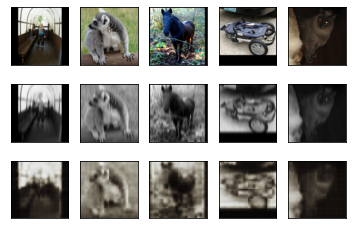

Epoch : [15/25] 

Training Loss: 0.013199	 validation Loss 0.006651
PNSR :22.65 	 SSIM : 0.63
PNSR :17.01 	 SSIM : 0.69
PNSR :7.12 	 SSIM : 0.45
PNSR :17.51 	 SSIM : 0.59
PNSR :19.67 	 SSIM : 0.89


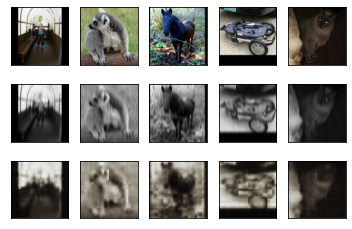

Epoch : [16/25] 

Training Loss: 0.013195	 validation Loss 0.006597
PNSR :22.86 	 SSIM : 0.63
PNSR :17.33 	 SSIM : 0.68
PNSR :7.21 	 SSIM : 0.45
PNSR :17.52 	 SSIM : 0.59
PNSR :20.09 	 SSIM : 0.89


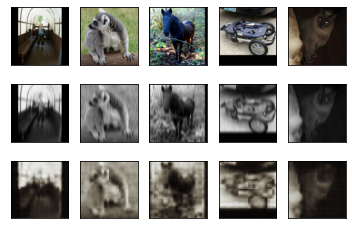

Epoch : [17/25] 

Training Loss: 0.013193	 validation Loss 0.006654
PNSR :22.70 	 SSIM : 0.63
PNSR :17.00 	 SSIM : 0.69
PNSR :7.11 	 SSIM : 0.45
PNSR :17.50 	 SSIM : 0.59
PNSR :19.65 	 SSIM : 0.89


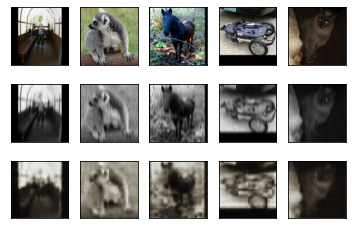

Epoch : [18/25] 

Training Loss: 0.013190	 validation Loss 0.006648
PNSR :22.64 	 SSIM : 0.63
PNSR :16.99 	 SSIM : 0.68
PNSR :7.10 	 SSIM : 0.45
PNSR :17.51 	 SSIM : 0.59
PNSR :19.62 	 SSIM : 0.89


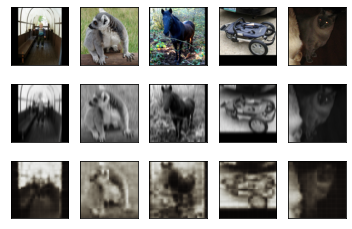

Epoch : [19/25] 

Training Loss: 0.013187	 validation Loss 0.006647
PNSR :22.68 	 SSIM : 0.63
PNSR :17.03 	 SSIM : 0.68
PNSR :7.11 	 SSIM : 0.45
PNSR :17.51 	 SSIM : 0.59
PNSR :19.68 	 SSIM : 0.89


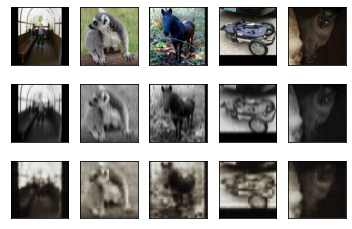

Epoch : [20/25] 

Training Loss: 0.013183	 validation Loss 0.006649
PNSR :22.64 	 SSIM : 0.63
PNSR :16.97 	 SSIM : 0.69
PNSR :7.09 	 SSIM : 0.45
PNSR :17.52 	 SSIM : 0.59
PNSR :19.63 	 SSIM : 0.89


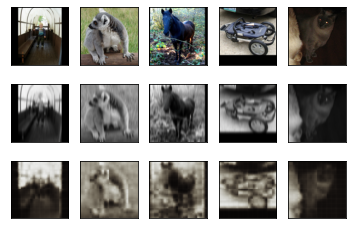

Epoch : [21/25] 

Training Loss: 0.013181	 validation Loss 0.006638
PNSR :22.64 	 SSIM : 0.63
PNSR :16.99 	 SSIM : 0.69
PNSR :7.10 	 SSIM : 0.45
PNSR :17.52 	 SSIM : 0.59
PNSR :19.64 	 SSIM : 0.89


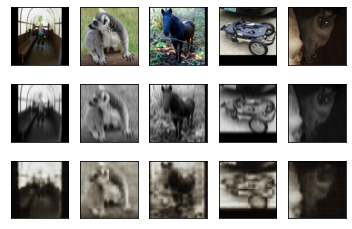

Epoch : [22/25] 

Training Loss: 0.013180	 validation Loss 0.006636
PNSR :22.57 	 SSIM : 0.63
PNSR :16.94 	 SSIM : 0.69
PNSR :7.09 	 SSIM : 0.45
PNSR :17.50 	 SSIM : 0.59
PNSR :19.56 	 SSIM : 0.89


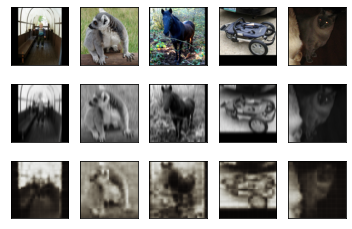

Epoch : [23/25] 

Training Loss: 0.013178	 validation Loss 0.006622
PNSR :22.67 	 SSIM : 0.63
PNSR :17.13 	 SSIM : 0.69
PNSR :7.12 	 SSIM : 0.45
PNSR :17.57 	 SSIM : 0.59
PNSR :19.81 	 SSIM : 0.89


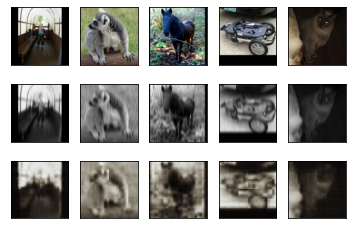

Epoch : [24/25] 

Training Loss: 0.013175	 validation Loss 0.006622
PNSR :22.59 	 SSIM : 0.63
PNSR :17.03 	 SSIM : 0.68
PNSR :7.11 	 SSIM : 0.45
PNSR :17.54 	 SSIM : 0.59
PNSR :19.69 	 SSIM : 0.89


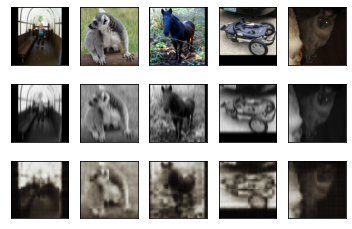

Epoch : [25/25] 

Training Loss: 0.013174	 validation Loss 0.006621
PNSR :22.60 	 SSIM : 0.63
PNSR :17.06 	 SSIM : 0.69
PNSR :7.12 	 SSIM : 0.45
PNSR :17.54 	 SSIM : 0.59
PNSR :19.73 	 SSIM : 0.89


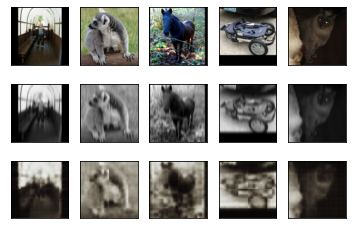

execution time : 24.4min


In [26]:
device = get_device()
print(device)
model_weak = DenosingAutoencoder()
optimizer_weak = torch.optim.Adam(model_weak.parameters(), lr=0.001, weight_decay  = 1e-04)
model_weak=model_weak.to(device)

weak_train_loss_graph = np.array([])
weak_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_weak.train()
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0
    tr_dataloader_iter = iter(tr_dataloader)
    hat_tr_dataloader_iter = iter(Gs_blur_weak_tr_dataloader)
    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i in range(len(tr_dataloader)):
        tr_images,_ = next(tr_dataloader_iter)
        tr_images = tr_images.to(device)
#        print(tr_images_arr.shape)
        hat_tr_images,_ = next(hat_tr_dataloader_iter)
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device)
#check   print(tr_images.shape)
        optimizer_weak.zero_grad()
#check0. print(hat_tr_images.shape)  
        tr_outputs =model_weak(hat_tr_images)
#check   print(tr_outputs.shape)
        loss = mse_loss(tr_outputs, tr_images)
        loss.backward()
        optimizer_weak.step()
        train_loss = loss.item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    weak_train_loss_graph = np.append(weak_train_loss_graph, total_train_loss)


    #evaluation
    model_weak.eval()

    with torch.no_grad():   
        optimizer_weak.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, Gs_blur_weak_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                val_img = val_img.to(device)
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_weak(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        weak_val_loss_graph = np.append(weak_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().detach().numpy().transpose(1, 2, 0), val_outputs[j].cpu().detach().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j], max_val = 1.0)
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()
total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
PATH1 = '/content/drive/MyDrive/model/model_weak.pth'
torch.save(model_weak.state_dict(), PATH1)

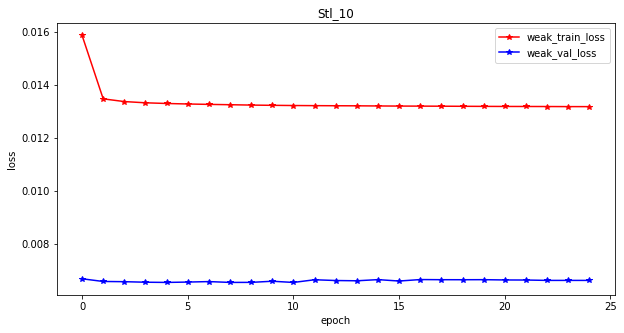

In [34]:
plt.figure(figsize=(10,5))
plt.plot(weak_train_loss_graph,'r-*')
plt.plot(weak_val_loss_graph, 'b-*')
plt.legend(['weak_train_loss','weak_val_loss'])
plt.title("Stl_10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('./weak_loss_graph.png')


# Weak test

In [40]:

Gs_blur_weak_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (11,11),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_weak_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_weak_test_dataloader = DataLoader(Gs_blur_weak_test_dataset, batch_size = batch_size, num_workers = 4)

In [ ]:
Gs_blur_weak_tr_dataset = []
for i in range(80000):
  hat_img_train_set_arr = cv2.GaussianBlur(img_train_set_arr[i], (11,11),0)
  hat_img_train_set_tensor_byte = torch.from_numpy(hat_img_train_set_arr)
  hat_img_train_set_tensor_float = hat_img_train_set_tensor_byte.float()
  hat_img_train_set_tensor_normal = hat_img_train_set_tensor_float.div(255.0)
  Gs_blur_weak_tr_dataset.append([hat_img_train_set_tensor_normal,0])

# moderate graph

In [ ]:
#모델 세이브

PATH2 = './model/Gs_blur_moderate_DAE_model.pth'
PATH3 = './model/Gs_blur_strong_DAE_model.pth'

torch.save(mode2.state_dict(), PATH2)
torch.save(mode3.state_dict(), PATH3)

# test graph for (average psnr, ssim)

PNSR :12.45 	 SSIM : 0.65
PNSR :13.34 	 SSIM : 0.63
PNSR :12.90 	 SSIM : 0.40
PNSR :18.51 	 SSIM : 0.72
PNSR :18.75 	 SSIM : 0.69
PNSR :14.22 	 SSIM : 0.83
PNSR :12.81 	 SSIM : 0.74
PNSR :11.46 	 SSIM : 0.57
PNSR :14.29 	 SSIM : 0.56
PNSR :13.92 	 SSIM : 0.71


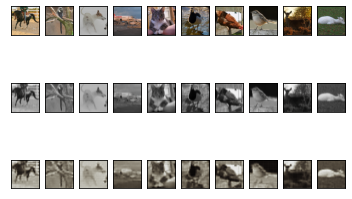

avg_psnr : 14.26
avg_ssim : 0.65


In [61]:
sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_weak.eval()
with torch.no_grad():
    optimizer_weak.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_weak_test_dataloader)):
        
        weak_test_img, _ = test_img
        weak_test_img = weak_test_img.to(device)
        weak_test_hat_img, _ = hat_test_img
        weak_test_hat_img = weak_test_hat_img.to(device)

        test_outputs = model_weak(weak_test_hat_img)
        
    for j in range(10):
        img1_cpu = weak_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        weak_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        weak_psnr = Get_psnr(weak_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=weak_psnr
        sum_ssim+=weak_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(weak_psnr,weak_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))
